In [1]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0,
)

In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define method for creating agents and binding them to the tools
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

In [4]:
import functools

# Create nodes with each agent
def agent_node(state, agent, name):
  result = agent.invoke(state)
  return {
      'messages': [result]
  }

In [5]:
import re
import json
from pathlib import Path
from langchain.agents import tool
from typing import List

def extract_speaker_names(transcript: str) -> List[str]:
    pattern = re.compile(r"\*\*\[\d{2}:\d{2}:\d{2}\]\s([^:]+):\*\*")
    matches = pattern.findall(transcript)
    # Remove duplicates and preserve order
    seen = set()
    unique_names = []
    for name in matches:
        if name not in seen:
            seen.add(name)
            unique_names.append(name)
    return unique_names

transformer_template = """You are a transcript transformer agent.

Your task is to process a meeting transcript and return it in structured JSON format. For each line of the transcript, extract the speaker's name, timestamp (if provided), and spoken message.

You must also determine the speaker’s role using the provided tool `assign_static_roles`, which returns a list of role assignments based on a database of employees.

Follow these rules:
1. Use the `assign_static_roles` tool on the full transcript to retrieve roles for all mentioned names.
2. Format the output as a JSON array. Each entry should follow this structure:
   {
     "timestamp": "<timestamp if available or null>",
     "name": "<speaker's name>",
     "role": "<role from tool, e.g., 'Engineer L2'>",
     "message": "<spoken text>"
   }
3. If no timestamp is provided in the transcript line, set the "timestamp" field to null.
4. Do not invent or modify roles. Use exactly the values returned from the tool.
5. Preserve the original message content as accurately as possible.

Return only the final JSON array and nothing else."""

PEOPLE_DB_PATH = Path("app/data/37signals_employees.json")

def load_people_db():
    with open(PEOPLE_DB_PATH, "r") as f:
        return json.load(f)

@tool
def assign_static_roles(transcript: str) -> str:
    """
    Assign roles to people in the transcript using static rules and a people DB.
    Returns: JSON string of [{name, role}]
    """
    names_in_meeting = extract_speaker_names(transcript)
    people_db = load_people_db()

    assigned = []
    for name in names_in_meeting:
        match = next((p for p in people_db if p["name"] == name), None)
        assigned.append({
            "name": name,
            "role": f"{match['role']} L{match['level']}" if match else "Unknown"
        })

    return json.dumps(assigned, indent=2)

transformer_agent = create_agent(llm, [assign_static_roles], transformer_template)
transformer_node = functools.partial(agent_node, agent=transformer_agent, name="Transformer Agent")

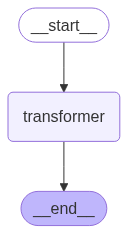

In [6]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

workflow = StateGraph(AgentState)

workflow.add_node("transformer", transformer_node)
workflow.set_entry_point("transformer")
workflow.add_edge("transformer", END)

graph = workflow.compile()

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [7]:
from langchain_core.messages import HumanMessage

transcript_path = Path("data/37signals_transcript_technical.md")
transcript_text = transcript_path.read_text(encoding="utf-8")

input_message = HumanMessage(content=transcript_text)

for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  assign_static_roles (call_sc4B0DiwXOja5673a2pjdqrZ)
 Call ID: call_sc4B0DiwXOja5673a2pjdqrZ
  Args:
    transcript: Engineering Sync – Code Refactor and Observability Improvements

**Date:** 2025-05-30

## Discussions

**[00:00:02] Loretta Perez:**  
Alright, folks, thanks for making the time today. I know everyone's knee-deep in various threads, but this session should help align a few of them — namely the ongoing module refactor and some of the observability pain points we flagged last week. The goal is to come out of this with fewer unknowns and ideally fewer late-night Slack pings. Let's start with the refactor. Rachel, you’ve been leading most of the `EventRouter` changes — can you give us a rundown of where things stand?

**[00:00:29] Rachel Aguirre:**  
Yep, absolutely. So, we’ve made solid progress on decoupling the event logic from the main `GameCore`. Right now, the `EventRouter` ha